In [76]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from itertools import combinations
from scipy.stats import ttest_ind
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [161]:
# DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
# df_train = pd.read_csv(DATA_DIR+'main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
df_train = pd.read_csv('g:\SkillFactory\о вкусной и здоровой пище\Данные\main_task.csv')
df_test = pd.read_csv('g:\SkillFactory\о вкусной и здоровой пище\Данные\kaggle_task.csv')
sample_submission = pd.read_csv('g:\SkillFactory\о вкусной и здоровой пище\Данные\sample_submission.csv')
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort = False).reset_index(drop = True) # объединяем

In [3]:
# функция расчета выбросов
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

In [4]:
# функция расчета стаистических закономерностей
def get_stat_dif(column):
    cols = df_stat.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_stat.loc[df_stat.loc[:, column] == comb[0], 'rating'], 
                        df_stat.loc[df_stat.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [5]:
# функция округления результатов предсказания
def round_pred(y_pred):
    return [(round(y / 0.5) * 0.5) for y in y_pred]

In [6]:
# функция minmax нормализации столбца датасета
def MMS(ser):
    scaler = MinMaxScaler()
    x = np.array(ser).reshape(len(ser), 1)
    a = scaler.fit_transform(x)
    a_s = pd.Series(a.flatten())
    return a_s

In [7]:
# функция std нормализации столбца датасета
def stdS(ser):
    scaler = StandardScaler()
    x = np.array(ser).reshape(len(ser), 1)
    a = scaler.fit_transform(x)
    a_s = pd.Series(a.flatten())
    return a_s

In [8]:
df

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


In [9]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [162]:
df.columns = ['id', 'city', 'cuisine', 'ranking',
       'price', 'number', 'reviews', 'URL_TA', 'ID_TA',
       'sample','rating']

In [11]:
df

,id,city,cuisine,ranking,price,number,reviews,URL_TA,ID_TA,sample,rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       50000 non-null  object 
 1   city     50000 non-null  object 
 2   cuisine  38410 non-null  object 
 3   ranking  50000 non-null  float64
 4   price    32639 non-null  object 
 5   number   46800 non-null  float64
 6   reviews  49998 non-null  object 
 7   URL_TA   50000 non-null  object 
 8   ID_TA    50000 non-null  object 
 9   sample   50000 non-null  int64  
 10  rating   50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


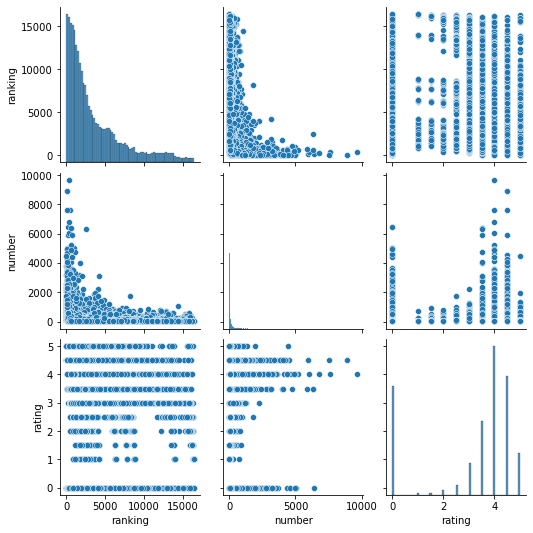

In [13]:
sns.pairplot(df.drop(['sample'], axis = 1))




# cuisine

In [14]:
df.cuisine

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: cuisine, Length: 50000, dtype: object

In [15]:
df.cuisine[1]

"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"

получилась строка списка строк, нужно преобразовывать

In [16]:
# считаем количесвто нулевых строк
df.cuisine.isna().sum()

11590

In [17]:
# количесвто нулевых строк в процентах
df.cuisine.isna().sum()/len(df)*100

23.18

мы видим очень много пустых строк, но в ресторане не может не быть кухни, как минимум одна все равно есть

In [163]:
# преобразуем строку списка в список и пустые строки назовем стандартная кухня
df3 = df.cuisine
df3 = df3.fillna('[standart]')
df3 = df3.apply(lambda x: str(x)[1:-1])
df3 = df3.apply(lambda x: x.replace("'", ''))
df3 = df3.str.split(', ')

In [19]:
# посмотрим на результат
df3[1]

['European',
 'Scandinavian',
 'Gluten Free Options',
 'Vegetarian Friendly',
 'Vegan Options']

In [164]:
# посчитаем количество кухонь
cuisine_all = df3.explode()
print(cuisine_all.value_counts())
print(cuisine_all.value_counts(normalize = True))
print(cuisine_all.nunique())

Vegetarian Friendly    14021
European               12561
standart               11590
Mediterranean           7820
Italian                 7433
                       ...  
Yunnan                     2
Burmese                    1
Xinjiang                   1
Salvadoran                 1
Latvian                    1
Name: cuisine, Length: 126, dtype: int64
Vegetarian Friendly    0.106814
European               0.095691
standart               0.088294
Mediterranean          0.059574
Italian                0.056625
                         ...   
Yunnan                 0.000015
Burmese                0.000008
Xinjiang               0.000008
Salvadoran             0.000008
Latvian                0.000008
Name: cuisine, Length: 126, dtype: float64
126


In [81]:
# проверим колонку на наличие статистически значимых различий
df_stat = pd.DataFrame()
df_stat['cuisine'] = df3
df_stat['rating'] = df['rating']
df_stat['sample'] = df['sample']
df_stat = df_stat.explode('cuisine')
df_stat = df_stat[df_stat['sample'] == 1]
df_stat = df_stat[df_stat['cuisine'] != '']
get_stat_dif('cuisine')

Найдены статистически значимые различия для колонки cuisine


In [165]:
df3_c = df3.apply(lambda x: len(x))
print(df3_c.unique())
print(df3_c.value_counts())
print(df3_c.value_counts(normalize = True))
df['cuisine_c'] = df3_c

[ 2  5  1  6  3  4  7  8  9 10 15 11 13 21]
1     20744
2      7794
3      6638
4      5948
5      4482
6      2611
7      1294
8       363
9        93
10       26
11        4
21        1
15        1
13        1
Name: cuisine, dtype: int64
1     0.41488
2     0.15588
3     0.13276
4     0.11896
5     0.08964
6     0.05222
7     0.02588
8     0.00726
9     0.00186
10    0.00052
11    0.00008
21    0.00002
15    0.00002
13    0.00002
Name: cuisine, dtype: float64


C:\Users\1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


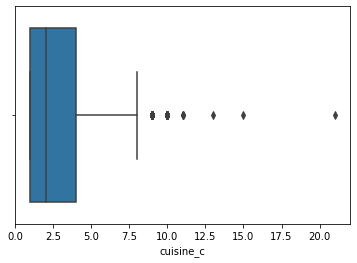

In [23]:
sns.boxplot(df['cuisine_c']);

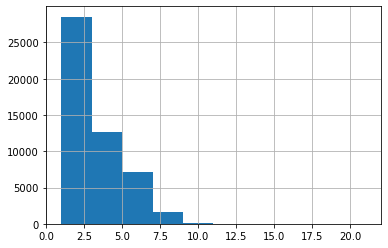

In [24]:
df.cuisine_c.hist();

In [25]:
print('выбросы', outliers_iqr(df.cuisine_c))

выбросы (-3.5, 8.5)


In [26]:
df[df.cuisine_c > 8.5]

,id,city,cuisine,ranking,price,number,reviews,URL_TA,ID_TA,sample,rating,cuisine_c
679,id_679,Madrid,"['Mexican', 'Latin', 'Contemporary', 'Fusion',...",168.0,$$ - $$$,144.0,[['Great Mexican cuisine is a lively neighbor....,/Restaurant_Review-g187514-d10494492-Reviews-M...,d10494492,0,0.0,9
832,id_832,Budapest,"['Italian', 'French', 'German', 'European', 'H...",422.0,$$ - $$$,41.0,"[['Nice place, nice staff', 'Perfect'], ['11/1...",/Restaurant_Review-g274887-d11806031-Reviews-M...,d11806031,0,0.0,10
1358,id_1358,Budapest,"['International', 'Grill', 'Barbecue', 'Europe...",319.0,$$ - $$$,241.0,"[['Good value for your money', 'Nice evening d...",/Restaurant_Review-g274887-d1023224-Reviews-Tr...,d1023224,0,0.0,9
2292,id_2292,Vienna,"['German', 'Austrian', 'European', 'Asian', 'C...",1379.0,$$ - $$$,42.0,"[['Traditional Austrian dishes', 'Delicious Au...",/Restaurant_Review-g190454-d1907599-Reviews-Gi...,d1907599,0,0.0,10
3184,id_3184,Rome,"['Italian', 'Pizza', 'Seafood', 'Mediterranean...",774.0,$$ - $$$,893.0,"[['Waterfront experience', 'Excellent location...",/Restaurant_Review-g187791-d1641052-Reviews-Cu...,d1641052,0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...
48241,id_17,Edinburgh,"['Mediterranean', 'Barbecue', 'Turkish', 'Euro...",18.0,$$ - $$$,440.0,"[['Dinner', 'Still the best'], ['01/10/2018', ...",/Restaurant_Review-g186525-d8699437-Reviews-Ad...,d8699437,1,4.5,9
49276,id_67,Warsaw,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",68.0,$$ - $$$,180.0,"[['Good place in Warsaw', 'Exceeded the expect...",/Restaurant_Review-g274856-d3854108-Reviews-Le...,d3854108,1,4.5,9
49413,id_93,Amsterdam,"['Asian', 'Italian', 'French', 'American', 'In...",94.0,$$ - $$$,1480.0,"[['Amazing place, great food & vibe - you MUS....",/Restaurant_Review-g188590-d7231902-Reviews-Fo...,d7231902,1,4.5,21
49614,id_106,Edinburgh,"['American', 'Bar', 'British', 'Pub', 'Scottis...",107.0,$$ - $$$,1072.0,"[['Great burgers!', 'Great for meat lovers, bu...",/Restaurant_Review-g186525-d1811602-Reviews-Th...,d1811602,1,4.5,9


In [166]:
df.cuisine_c = df.cuisine_c.apply(lambda x: np.log(x))
print('максимальное значение', df.cuisine_c.max())
print('выбросы', outliers_iqr(df.cuisine_c))
print('значения и их количество', df.cuisine_c.value_counts())

максимальное значение 3.044522437723423
выбросы (-2.0794415416798357, 3.465735902799726)
значения и их количество 0.000000    20744
0.693147     7794
1.098612     6638
1.386294     5948
1.609438     4482
1.791759     2611
1.945910     1294
2.079442      363
2.197225       93
2.302585       26
2.397895        4
2.708050        1
2.564949        1
3.044522        1
Name: cuisine_c, dtype: int64


<AxesSubplot:>

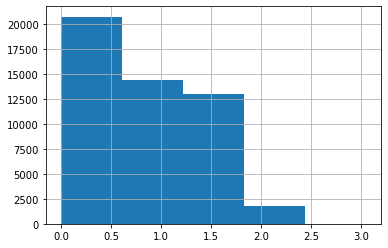

In [28]:
df.cuisine_c.hist(bins = 5)

C:\Users\1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


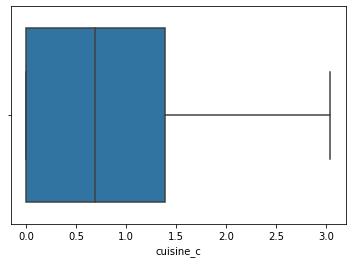

In [29]:
sns.boxplot(df.cuisine_c);

# rating

уникальные значения [0.  3.5 4.  4.5 5.  3.  2.5 2.  1.  1.5]
значения и их количество 4.0    13692
4.5    10929
0.0    10000
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64


<AxesSubplot:>

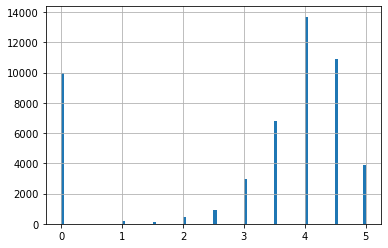

In [30]:
print('уникальные значения', df.rating.unique())
print('значения и их количество', df.rating.value_counts())
df.rating.hist(bins = 100)

# price

In [167]:
print('уникальные значения', df.price.unique())
price_vl = df.price.value_counts()
print('значения и их количество\n', price_vl)
print(df.price.isna().sum()/50000*100)
print(df[df['sample'] == 0].price.isna().sum())
print(df[df['sample'] == 1].price.isna().sum())

уникальные значения ['$$ - $$$' '$$$$' '$' nan]
значения и их количество
 $$ - $$$    23041
$            7816
$$$$         1782
Name: price, dtype: int64
34.721999999999994
3475
13886


In [32]:
# проверим колонку на наличие статистически значимых различий
df_stat = pd.DataFrame()
df_stat['price'] = df['price']
df_stat['rating'] = df['rating']
df_stat['sample'] = df['sample']
df_stat = df_stat[df['sample'] == 1]
get_stat_dif('price')

Найдены статистически значимые различия для колонки price


In [168]:
# пометим строки, где есть NaN
df['price_ind'] = df.price.isna()
df['price_ind'] = df['price_ind'].apply(lambda x: 0 if x else 1)

In [169]:
# заменим пропуски пропорционально имеющимся данным
price_list = [price_vl.index[x] for x in range(3)]
p = [price_vl[z]/price_vl.sum() for z in range(3)]
print(price_list, p)
a = np.random.choice(price_list, df.price.isna().sum(), p=p)
count = 0
for i in range(len(df.price)):
    if pd.isna(df.loc[i, 'price']) :
        df.loc[i, 'price'] = a[count]
        count += 1
print(df.price.value_counts())

['$$ - $$$', '$', '$$$$'] [0.7059346180949171, 0.23946812095958822, 0.054597260945494656]
$$ - $$$    35300
$           11971
$$$$         2729
Name: price, dtype: int64


<AxesSubplot:>

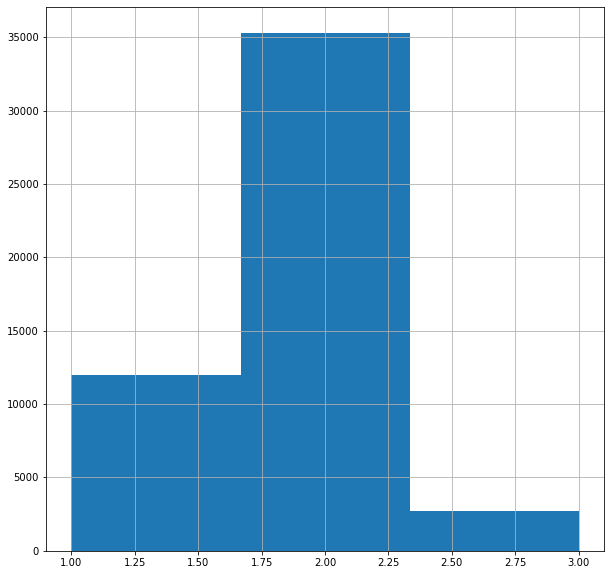

In [170]:
# сохраним колонку с категориальными значениями для последующего преобразования в dummy-переменные
df['price1'] = df.price.copy()
# заменим на числовыми значениями по принципу LabelEncoding
df.price = df.price.apply(lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3)
df.price.hist(bins = 3)

In [36]:
# проверим колонку на наличие статистически значимых различий после манипуляций
df_stat = pd.DataFrame()
df_stat['price'] = df['price']
df_stat['rating'] = df['rating']
df_stat['sample'] = df['sample']
df_stat = df_stat[df['sample'] == 1]
get_stat_dif('price')

Найдены статистически значимые различия для колонки price


# number

значения и их количество
 2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: number, Length: 1573, dtype: int64
количество пустых строк 3200


<AxesSubplot:>

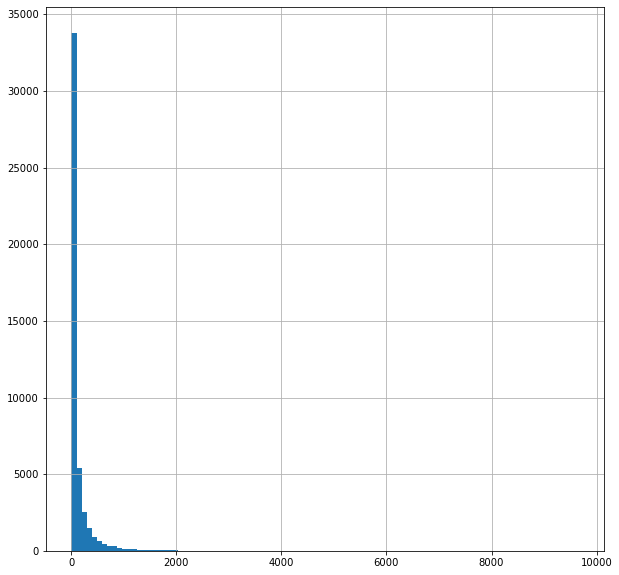

In [171]:
print('значения и их количество\n', df.number.value_counts())
print('количество пустых строк', df.number.isna().sum())
# пометим строки, где есть NaN
df['number_ind'] = df.number.isna()
df['number_ind'] = df['number_ind'].apply(lambda x: 0 if x else 1)
df.number.hist(bins = 100)

In [172]:
df_isna = df[df.number.isna()]
df_isna['reviews'].unique()

array(['[[], []]', '[["Nova\' Doba"], [\'01/26/2017\']]',
       "[['South American food at its best!'], ['09/05/2013']]", ...,
       "[['Small, Friendly Place on the Mile'], ['11/15/2015']]",
       "[['Personal expirence'], ['10/27/2017']]",
       "[['I love this place!'], ['08/24/2015']]"], dtype=object)

In [173]:
df_isna['reviews'].nunique()

1177

In [174]:
df_isna.reviews.isna().sum()

1

In [175]:
df_isna[df_isna.reviews.isna()]

,id,city,cuisine,ranking,price,number,reviews,URL_TA,ID_TA,sample,rating,cuisine_c,price_ind,price1,number_ind
9608,id_9608,Vienna,NaN,1779.0,1,NaN,NaN,/Restaurant_Review-g190454-d12605368-Reviews-R...,d12605368,0,0.0,0.0,0,$,0


In [176]:
df_isna['reviews'].value_counts()

[[], []]                                                               2023
[['OK Noodles, no athmosphere'], ['09/13/2016']]                          1
[['Value for money'], ['12/15/2013']]                                     1
[["Fresh and Vibrant, It's more than just Jui..."], ['02/13/2015']]       1
[['shockingly dissapointed'], ['10/23/2017']]                             1
                                                                       ... 
[['Delicious pastries, not so nice interior'], ['08/27/2015']]            1
[['Unique Chicken Shop'], ['01/27/2017']]                                 1
[['Cozy rum bar'], ['11/03/2016']]                                        1
[['Filling portions at any time of day or nig...'], ['06/29/2015']]       1
[['Mixed report; but overall good'], ['06/13/2017']]                      1
Name: reviews, Length: 1177, dtype: int64

In [177]:
df_isna['reviews'].value_counts().index[0][2]

']'

In [120]:
df.number.median()

33.0

In [178]:
for i in range(len(df)):
    if pd.isna(df.loc[i, 'number']):
        if not pd.isna(df.loc[i, 'reviews']):
            if df.loc[i, 'reviews'][2] != ']':
                df.loc[i, 'number'] = 1

In [179]:
df.number.isna().sum()

2024

In [180]:
df.number.fillna(0, inplace = True)

In [181]:
outliers_iqr(df.number)

(-140.0, 252.0)

In [182]:
df[df.number > 252.0]

,id,city,cuisine,ranking,price,number,reviews,URL_TA,ID_TA,sample,rating,cuisine_c,price_ind,price1,number_ind
10,id_10,Rome,NaN,1209.0,2,306.0,"[['Very pretentious, but drinks are top notch'...",/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,0.0,0.000000,0,$$ - $$$,1
14,id_14,Prague,"['European', 'Czech', 'Eastern European', 'Cen...",1105.0,2,273.0,"[['Good food, beer, value and service', 'Eat u...",/Restaurant_Review-g274707-d1093021-Reviews-U_...,d1093021,0,0.0,1.386294,1,$$ - $$$,1
16,id_16,Milan,"['Pizza', 'Vegetarian Friendly', 'Vegan Options']",1825.0,2,322.0,"[['truly Neapolitan pizza, new/slick location'...",/Restaurant_Review-g187849-d11850449-Reviews-P...,d11850449,0,0.0,1.098612,1,$$ - $$$,1
17,id_17,London,"['Bar', 'British', 'Pub', 'Vegetarian Friendly...",2349.0,2,282.0,"[['Quite a decent pub', 'in the middle of noth...",/Restaurant_Review-g186338-d2188276-Reviews-Th...,d2188276,0,0.0,1.609438,1,$$ - $$$,1
29,id_29,Oslo,"['French', 'European', 'Norwegian', 'Italian',...",550.0,2,465.0,"[['Lovely food!', 'Nightmare'], ['02/26/2017',...",/Restaurant_Review-g190479-d1495732-Reviews-Mo...,d1495732,0,0.0,1.791759,1,$$ - $$$,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49980,id_253,Rome,"['Italian', 'Seafood', 'Mediterranean', 'Europ...",254.0,2,560.0,[['Creative cocktails and pleasant atmosphere....,/Restaurant_Review-g187791-d8273642-Reviews-Su...,d8273642,1,4.5,1.791759,1,$$ - $$$,1
49985,id_56,Brussels,"['African', 'Ethiopian', 'Vegetarian Friendly'...",57.0,2,989.0,"[['A nice experience with Ethiopian food', 'A ...",/Restaurant_Review-g188644-d778285-Reviews-Kok...,d778285,1,4.0,1.386294,1,$$ - $$$,1
49992,id_13,Stockholm,"['Swedish', 'Scandinavian', 'Vegetarian Friend...",14.0,2,1162.0,"[['Great Viking Dinner', 'A foot stompingly go...",/Restaurant_Review-g189852-d2560559-Reviews-Ai...,d2560559,1,4.5,1.386294,1,$$ - $$$,1
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,1.609438,1,$$ - $$$,1


In [41]:
# # заменим пропуски пропорционально имеющимся данным
# number_vl = df.number.value_counts()
# number_list = [number_vl.index[x] for x in range(len(number_vl))]
# p = [number_vl[z]/number_vl.sum() for z in number_vl.index]
# a = np.random.choice(number_list, df.number.isna().sum(), p=p)
# count = 0
# for i in range(len(df.number)):
#     if pd.isna(df.loc[i, 'number']) :
#         df.loc[i, 'number'] = a[count]
#         count += 1
# print(df.number.value_counts())

2.0       2564
3.0       2183
4.0       1819
5.0       1569
6.0       1349
          ... 
758.0        1
1063.0       1
1028.0       1
1108.0       1
1543.0       1
Name: number, Length: 1573, dtype: int64


In [183]:
# нормализуем колонку
df.number = MMS(df.number)

<AxesSubplot:>

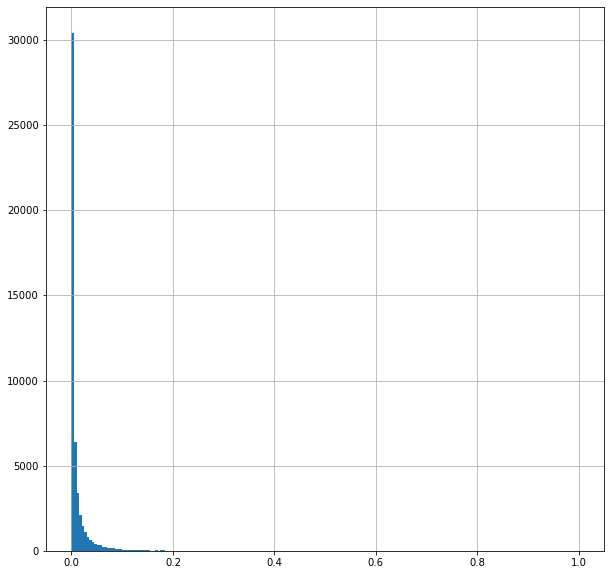

In [184]:
df.number.hist(bins = 200)

In [185]:
outliers_iqr(df.number)

(-0.014492753623188404, 0.02608695652173913)

In [186]:
df[df.number > 0.02608695652173913]

,id,city,cuisine,ranking,price,number,reviews,URL_TA,ID_TA,sample,rating,cuisine_c,price_ind,price1,number_ind
10,id_10,Rome,NaN,1209.0,2,0.031677,"[['Very pretentious, but drinks are top notch'...",/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,0.0,0.000000,0,$$ - $$$,1
14,id_14,Prague,"['European', 'Czech', 'Eastern European', 'Cen...",1105.0,2,0.028261,"[['Good food, beer, value and service', 'Eat u...",/Restaurant_Review-g274707-d1093021-Reviews-U_...,d1093021,0,0.0,1.386294,1,$$ - $$$,1
16,id_16,Milan,"['Pizza', 'Vegetarian Friendly', 'Vegan Options']",1825.0,2,0.033333,"[['truly Neapolitan pizza, new/slick location'...",/Restaurant_Review-g187849-d11850449-Reviews-P...,d11850449,0,0.0,1.098612,1,$$ - $$$,1
17,id_17,London,"['Bar', 'British', 'Pub', 'Vegetarian Friendly...",2349.0,2,0.029193,"[['Quite a decent pub', 'in the middle of noth...",/Restaurant_Review-g186338-d2188276-Reviews-Th...,d2188276,0,0.0,1.609438,1,$$ - $$$,1
29,id_29,Oslo,"['French', 'European', 'Norwegian', 'Italian',...",550.0,2,0.048137,"[['Lovely food!', 'Nightmare'], ['02/26/2017',...",/Restaurant_Review-g190479-d1495732-Reviews-Mo...,d1495732,0,0.0,1.791759,1,$$ - $$$,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49980,id_253,Rome,"['Italian', 'Seafood', 'Mediterranean', 'Europ...",254.0,2,0.057971,[['Creative cocktails and pleasant atmosphere....,/Restaurant_Review-g187791-d8273642-Reviews-Su...,d8273642,1,4.5,1.791759,1,$$ - $$$,1
49985,id_56,Brussels,"['African', 'Ethiopian', 'Vegetarian Friendly'...",57.0,2,0.102381,"[['A nice experience with Ethiopian food', 'A ...",/Restaurant_Review-g188644-d778285-Reviews-Kok...,d778285,1,4.0,1.386294,1,$$ - $$$,1
49992,id_13,Stockholm,"['Swedish', 'Scandinavian', 'Vegetarian Friend...",14.0,2,0.120290,"[['Great Viking Dinner', 'A foot stompingly go...",/Restaurant_Review-g189852-d2560559-Reviews-Ai...,d2560559,1,4.5,1.386294,1,$$ - $$$,1
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2,0.056108,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,1.609438,1,$$ - $$$,1


# reviews

In [187]:
# выделим из колонки даты и посчитаем разницу между ними
df4 = pd.DataFrame(df.reviews)
pattern = re.compile('\d+\/\d+\/\d+')
df4.reviews = df4.reviews.apply(lambda x: re.findall(pattern, str(x)))
df4['date2'] = df4.reviews.apply(lambda x: datetime.strptime(x[-1], '%m/%d/%Y') if len(x) == 2 else np.nan)
df4['date1'] = df4.reviews.apply(lambda x: datetime.strptime(x[0], '%m/%d/%Y') if len(x) == 2 or len(x) == 1 else np.nan)
df4['dt'] = df4.date1 - df4.date2
df4['dt'] = df4['dt'].apply(lambda x: x.days)

количество пустых строк 13798


<AxesSubplot:>

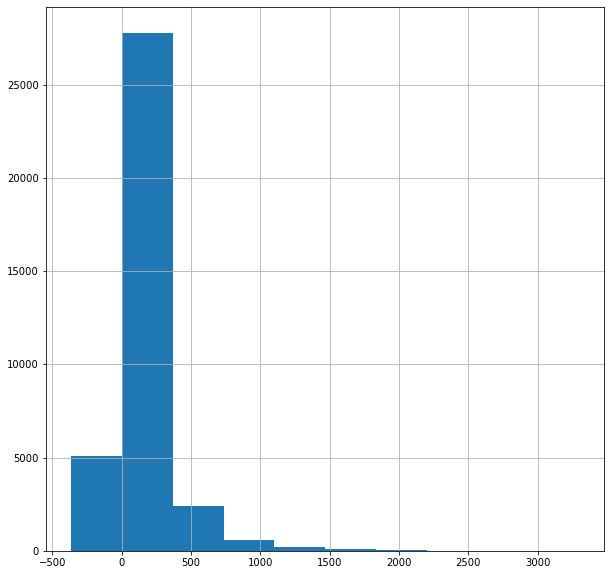

In [188]:
print('количество пустых строк', df4.dt.isna().sum())
# пометим пустые строки
df4['dt_ind'] = df4.dt.isna()
df4['dt_ind'] = df4['dt_ind'].apply(lambda x: 0 if x else 1)
df4.dt.hist()

In [189]:
# отрицательные значения сделаем положительными
df4.dt = np.abs(df4.dt)
dt_vl = df4.dt.value_counts()
print('значения и их количество\n', dt_vl)

значения и их количество
 1.0       829
0.0       631
2.0       629
3.0       606
4.0       538
         ... 
1124.0      1
918.0       1
2425.0      1
1355.0      1
1727.0      1
Name: dt, Length: 1310, dtype: int64


In [190]:
# заменим пропуски пропорционально имеющимся данным
dt_list = [dt_vl.index[x] for x in range(len(dt_vl))]
p = [dt_vl[z]/dt_vl.sum() for z in dt_vl.index]
a = np.random.choice(dt_list, df4.dt.isna().sum(), p=p)
count = 0
for i in range(len(df4.dt)):
    if pd.isna(df4.loc[i, 'dt']) :
        df4.loc[i, 'dt'] = a[count]
        count += 1
print(df4.dt.value_counts())

1.0       1196
0.0        886
2.0        864
3.0        853
4.0        737
          ... 
1779.0       1
659.0        1
1576.0       1
1001.0       1
1578.0       1
Name: dt, Length: 1310, dtype: int64


<AxesSubplot:>

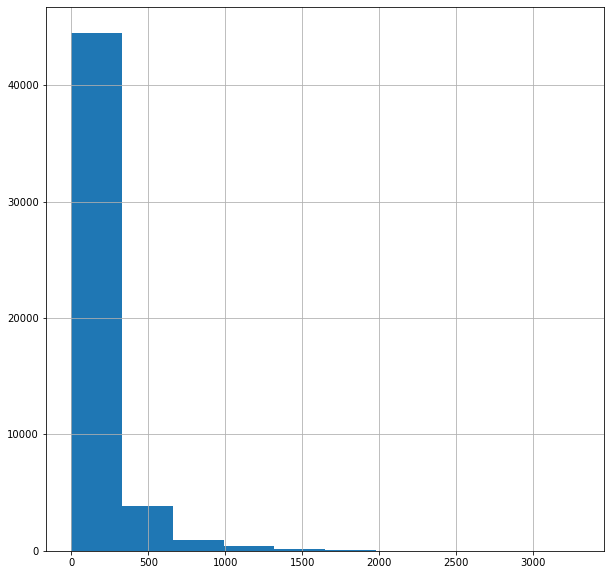

In [191]:
df4.dt.hist()

In [192]:
df['dt'] = df4.dt
df['dt_ind'] = df4['dt_ind']

In [193]:
df.dt = MMS(df.dt)

In [194]:
text = df.reviews.str.replace(',', '')

In [195]:
text.value_counts()

[[] []]                                                                                             8112
[['Excellent'] ['09/03/2015']]                                                                         2
[['Thursday snack' 'Good value for money & good food!'] ['03/13/2017' '06/20/2016']]                   2
[['The real codido madrileño'] ['03/31/2017']]                                                         2
[['Great coffee and pastries sandwiches ver...' 'Great breakfast!'] ['02/21/2017' '09/19/2016']]       2
                                                                                                    ... 
[['Great spot friendly staff' 'Nice vegan food'] ['10/24/2017' '02/28/2016']]                          1
[['Beyond Excellent' 'Dinner with friends'] ['01/07/2018' '12/29/2017']]                               1
[['The best' 'In the middle of the action'] ['12/02/2017' '11/03/2017']]                               1
[['Great cakes!' 'Excellent breakfast/pastry/service/de

In [196]:
pattern1 = re.compile('\D+')
text = text.apply(lambda x: re.findall(pattern1, str(x)))

In [197]:
analysisPol = text.apply(lambda x: TextBlob(str(x)).polarity)

In [198]:
df['analysisPol'] = analysisPol

In [199]:
analysisSub = text.apply(lambda x: TextBlob(str(x)).subjectivity)

In [200]:
df['analysisSub'] = analysisSub

<AxesSubplot:>

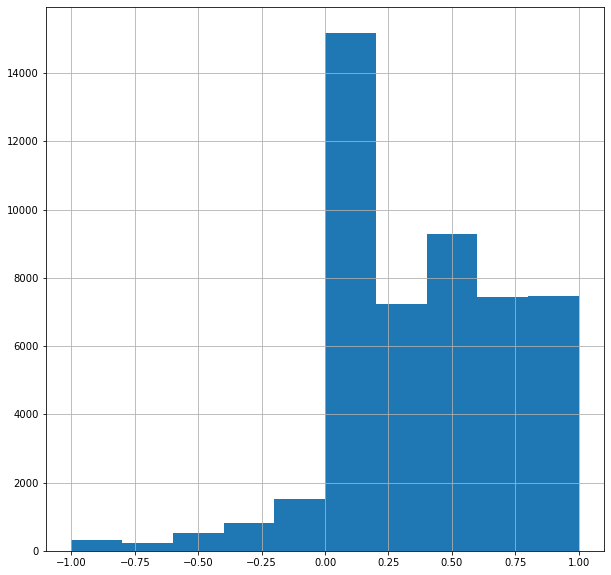

In [201]:
df['analysisPol'].hist()

<AxesSubplot:>

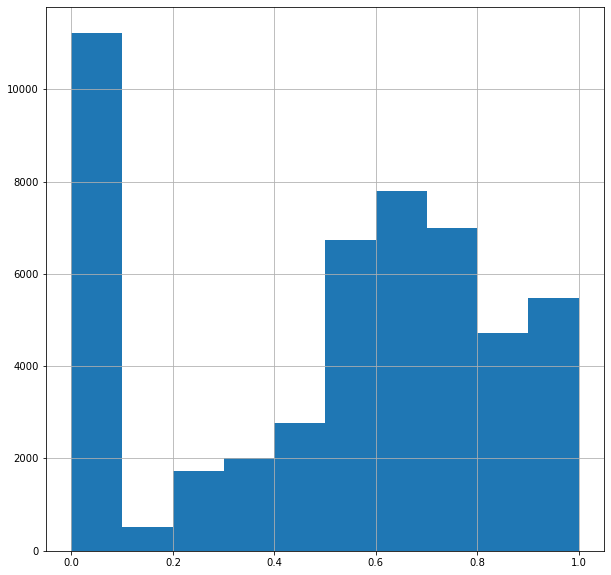

In [202]:
df['analysisSub'].hist()

In [203]:
corr_matrix = df.drop(columns=['id', 'sample']).corr(method='pearson')
corr_matrix

,ranking,price,number,rating,cuisine_c,price_ind,number_ind,dt,dt_ind,analysisPol,analysisSub
ranking,1.000000,-0.061680,-0.223156,-0.109897,-0.320777,-0.233946,-0.094831,0.101178,-0.149709,-0.204977,-0.118341
price,-0.061680,1.000000,0.134776,-0.008169,0.091715,-0.000083,0.010021,-0.037228,0.039375,0.015216,0.032793
number,-0.223156,0.134776,1.000000,0.011011,0.382942,0.266849,0.106146,-0.144184,0.227142,0.137815,0.143848
rating,-0.109897,-0.008169,0.011011,1.000000,0.034211,0.020519,0.000631,-0.024660,0.005490,0.081667,0.017122
cuisine_c,-0.320777,0.091715,0.382942,0.034211,1.000000,0.642196,0.196323,-0.222431,0.431717,0.240331,0.272759
price_ind,-0.233946,-0.000083,0.266849,0.020519,0.642196,1.000000,0.267568,-0.142745,0.511168,0.243355,0.329264
number_ind,-0.094831,0.010021,0.106146,0.000631,0.196323,0.267568,1.000000,-0.004478,0.423555,0.169902,0.260916
dt,0.101178,-0.037228,-0.144184,-0.024660,-0.222431,-0.142745,-0.004478,1.000000,-0.006424,-0.039363,-0.019164
dt_ind,-0.149709,0.039375,0.227142,0.005490,0.431717,0.511168,0.423555,-0.006424,1.000000,0.359071,0.562176
analysisPol,-0.204977,0.015216,0.137815,0.081667,0.240331,0.243355,0.169902,-0.039363,0.359071,1.000000,0.559503


<AxesSubplot:>

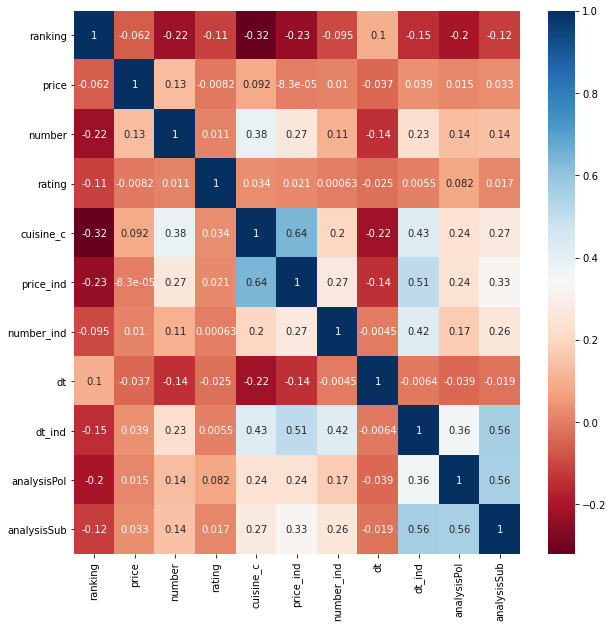

In [204]:
sns.heatmap(corr_matrix, annot = True, cmap="RdBu")

In [205]:
corr_matrix[(corr_matrix > 0.7) | (corr_matrix < -0.7)].fillna('')

,ranking,price,number,rating,cuisine_c,price_ind,number_ind,dt,dt_ind,analysisPol,analysisSub
ranking,1,,,,,,,,,,
price,,1,,,,,,,,,
number,,,1,,,,,,,,
rating,,,,1,,,,,,,
cuisine_c,,,,,1,,,,,,
price_ind,,,,,,1,,,,,
number_ind,,,,,,,1,,,,
dt,,,,,,,,1,,,
dt_ind,,,,,,,,,1,,
analysisPol,,,,,,,,,,1,


In [206]:
df = pd.get_dummies(df, columns=['city'], prefix='city')

In [207]:
df = pd.get_dummies(df, columns=['price1'], prefix='price')

In [65]:
df

,id,cuisine,ranking,price,number,reviews,URL_TA,ID_TA,sample,rating,...,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,price_$,price_$$ - $$$,price_$$$$
0,id_0,"['Bar', 'Pub']",12963.0,2,0.000207,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,1,0,0,0,0,0,0,0,1,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,0.009836,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,id_2,['Vegetarian Friendly'],810.0,2,0.002692,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,0.020708,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,0.016567,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2,0.007973,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,0,0,0,0,0,0,0,0,1,0
49996,id_6340,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2,0.055912,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,1,0,0,0,0,0,0,0,1,0
49997,id_1649,"['Japanese', 'Sushi']",1652.0,2,0.000207,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,0,0,0,1,0,0,0,0,1,0
49998,id_640,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2,0.007041,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,0,0,0,0,0,1,0,0,1,0


In [208]:
train_data = df[df['sample'] == 1].drop(columns=['id', 'cuisine', 'reviews', 'sample', 'URL_TA', 'ID_TA'])
test_data = df[df['sample'] == 0].drop(columns=['id', 'cuisine', 'reviews', 'sample', 'URL_TA', 'ID_TA'])

y = train_data.rating.values            # наш таргет
X = train_data.drop(columns='rating')

In [209]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [154]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [155]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [210]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [211]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21572562499999998


In [212]:
y_pred_rnd = round_pred(y_pred)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rnd))

MAE: 0.184375


<AxesSubplot:>

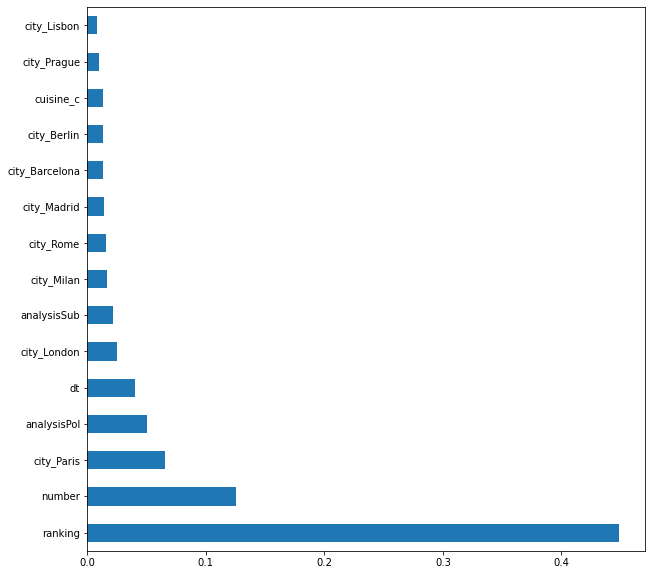

In [213]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [214]:
feat_importances[feat_importances > 0.009].sort_values()

city_Prague       0.010149
cuisine_c         0.013448
city_Berlin       0.013547
city_Barcelona    0.013599
city_Madrid       0.014067
city_Rome         0.015842
city_Milan        0.016907
analysisSub       0.021547
city_London       0.025197
dt                0.039968
analysisPol       0.050137
city_Paris        0.065898
number            0.125730
ranking           0.448233
dtype: float64